In [ ]:
#@title imports for nn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torchsummary import summary
from sklearn.model_selection import KFold, train_test_split
from tqdm import tqdm

import numpy as np
from google.colab import files
import io

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=8d925cad7139c1ddcdf5ebee2969c68bba754395a576332f758c5e3523bb825b
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
#@title imports for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
### Reading balanced training data, unbalanced testing data

Xtrain_balanced = np.load('balanced_training_1,2,3_vectors.npy').astype('float32')
Ytrain_balanced = np.load('balanced_training_1,2,3_difficulty.npy').astype('float32')

Ytrain_balanced = np.array([y-1 for y in Ytrain_balanced])

Xtest_unbalanced = np.load('unbalanced_testing_1,2,3_vectors.npy').astype('float32')
Ytest_unbalanced = np.load('unbalanced_testing_1,2,3_difficulty.npy').astype('float32')

Ytest_unbalanced = np.array([y-1 for y in Ytest_unbalanced])

In [ ]:
Xtrain_balanced.shape,Ytrain_balanced.shape, Xtest_unbalanced.shape, Ytest_unbalanced.shape

((369, 43), (369,), (94, 43), (94,))

In [ ]:
### Reading vectors of binary labels

X = np.load('all_feed_forward_inputs.npy').astype('float32')
Y = np.load('binary_difficulty.npy').astype('int64')

FileNotFoundError: ignored

In [ ]:
### Test train split for binary labels
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [ ]:
### Test train variables for  123 labels

x_train = Xtrain_balanced
y_train = Ytrain_balanced
x_test = Xtest_unbalanced
y_test = Ytest_unbalanced

In [ ]:
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

y_train = torch.unsqueeze(y_train, 1)
y_test = torch.unsqueeze(y_test, 1)
y_train = y_train.long()
y_test = y_test.long()

In [ ]:
### FFD training function

def ffnn(neurons, lrate, eps):

  layer_sizes=[int(neurons)] 
  num_epochs=int(eps)
  batch_size = None
  learning_rate=lrate
  input_dim=43 
  output_dim=3
  output_vector_size=3

  epoch_loss = []
  layer_sizes = [input_dim]+layer_sizes+[output_dim]
  layer_list = []
  for l in range(len(layer_sizes)-1):
    layer_list.append(nn.Linear(layer_sizes[l],layer_sizes[l+1], bias=True))
    layer_list.append(nn.ReLU())

  layer_list = layer_list

  model = nn.Sequential(*layer_list[:-1])
                  
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

  avg_train_loss =  []
  avg_train_acc = []
  avg_test_loss = []
  avg_test_acc = []
    
  # pbar = tqdm(total=num_epochs)

  for epoch in range(num_epochs):
    training_loss = []
    model.train()
    for iteration in range(y_train.shape[0]):
      
      xi = x_train[iteration,:]
      yi = (y_train[iteration]).long()
      optimizer.zero_grad()
      y_logits = model(xi).unsqueeze(0)
      loss = criterion(y_logits, yi)
      loss.backward()
      optimizer.step()
      training_loss.append(loss.item())
    
    epoch_loss.append(sum(training_loss)/len(training_loss))
    # if epoch%10==0:
      # print("Epoch: ", epoch, "avg loss = ", sum(training_loss)/len(training_loss))
    
    model.eval()
    # Training Validation
    yval_logits = (model(x_train))
    yval_pred = torch.max(yval_logits,1)[1]
    v_loss = criterion(yval_logits, y_train.squeeze())
    v_acc = torch.mean((yval_pred==y_train.squeeze()).type(torch.float))
    avg_train_loss.append(v_loss.item())
    avg_train_acc.append(v_acc)

    # Testing Validation
    ytest_logits = (model(x_test))
    ytest_pred = torch.max(ytest_logits,1)[1]
    # t_loss = criterion(ytest_logits, y_test.squeeze())
    t_acc = torch.mean((ytest_pred == y_test.squeeze()).type(torch.float))
    # avg_test_loss.append(t_loss.item())
    avg_test_acc.append(t_acc)
    if t_acc>0.63:
      print("Testing acc > 63%", t_acc)
      break

  best_test_acc = max(avg_test_acc)
  overall_mean_test_acc = sum(avg_test_acc[-50:-1])/len(avg_test_acc[-50:-1])
  
  print(neurons, lrate, eps, best_test_acc, overall_mean_test_acc)
  return best_test_acc, model


In [ ]:
### Brute force nested for loops for picking best hyperparams

def multiple_nn_iters(listneurons, lrates, numepochs):
  for lns in listneurons:
    for lrs in lrates:
      for eps in numepochs:
        bta, hotmodel = ffnn(lns, lrs, eps)
        if bta>0.63:
          return hotmodel
  return None


In [ ]:
### Sample run

final_model_3 = multiple_nn_iters([30,40,50,60],[0.01,0.015,0.02, 0.025],[400,500,600])


30 0.01 400 tensor(0.5532) tensor(0.5115)
30 0.01 500 tensor(0.5957) tensor(0.5419)
30 0.01 600 tensor(0.5638) tensor(0.5248)
Testing acc > 63% tensor(0.6383)
30 0.015 400 tensor(0.6383) tensor(0.5569)


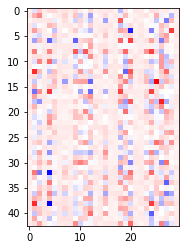

torch.Size([30, 43])
torch.Size([30])
torch.Size([3, 30])
torch.Size([3])


In [ ]:
### Interpreting NN weights 

for count,parameter in enumerate(final_model_3.parameters()):
  if count==0:
    param_arr = (np.array(parameter.data)).T
    plt.imshow(param_arr, cmap='bwr', interpolation='nearest')
    plt.show()

  print(parameter.data.shape)

In [ ]:
### Interpreting NN weights 

for count,parameter in enumerate(final_model.parameters()):
  if count==0:
    param_arr = (np.array(parameter.data)).T
  if count==1:
    param_bias = parameter.data
  
  # plt.imshow(param_arr, cmap='bwr', interpolation='nearest')
  # plt.show()

  print(parameter.data.shape)

torch.Size([50, 43])
torch.Size([50])
torch.Size([3, 50])
torch.Size([3])


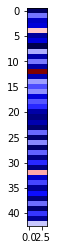

In [ ]:
### Interpreting NN weights 

plt.imshow(max_wts_expanded, cmap='seismic', interpolation='nearest')

In [ ]:
### Code to save models

PATH = "60plus_model_3.pt"

# Save
torch.save(final_model_3, PATH)


In [ ]:
### Checking  predictions  on full set (TEST + TRAIN)

fullx = torch.from_numpy(np.concatenate([x_train,x_test]))
fully = torch.from_numpy(np.concatenate([y_train,y_test]))

In [ ]:
fm  =  final_model_3
fm.eval()
    # Training Validation
fully_logits = (fm(fullx))
fully_pred = torch.max(fully_logits,1)[1]

t_acc = torch.mean((fully_pred == fully.squeeze()).type(torch.float))

print(t_acc)

tensor(0.8121)


In [ ]:
# np.array(fully_pred).
np.save('y_model_preds.npy', fully_pred) 
np.save('x_model_inputs.npy', fullx)


In [ ]:
#### BAYES OPT

pbounds = {'neurons': (20, 50), 'lrate': (0.01, 0.03), 'eps': (300,600)}

optimizer = BayesianOptimization(
    f=ffnn,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(init_points=5,n_iter=10)

|   iter    |  target   |    eps    |   lrate   |  neurons  |
-------------------------------------------------------------
|  31       |  0.5532   |  329.5    |  0.01842  |  48.74    |
|  32       |  0.5      |  459.9    |  0.02384  |  29.47    |
|  33       |  0.5957   |  506.0    |  0.02669  |  20.55    |
|  34       |  0.5213   |  525.0    |  0.02978  |  42.44    |
|  35       |  0.4468   |  384.1    |  0.02579  |  23.1     |
|  36       |  0.5532   |  400.4    |  0.03     |  50.0     |
|  37       |  0.5638   |  320.8    |  0.0161   |  34.12    |
|  38       |  0.5106   |  560.9    |  0.01235  |  39.57    |
|  39       |  0.5532   |  582.2    |  0.02166  |  49.67    |
|  40       |  0.5532   |  443.8    |  0.02995  |  20.19    |


In [ ]:
print(optimizer.max)

{'target': 0.6170212626457214, 'params': {'eps': 564.8457159088907, 'lrate': 0.015833134099966777, 'neurons': 49.9734972489653}}


In [ ]:
optimizer.maximize(init_points=5,n_iter=10)

|   iter    |  target   |    eps    |   lrate   |  neurons  |
-------------------------------------------------------------
|  1        |  0.4568   |  325.1    |  0.03881  |  30.0     |
|  2        |  0.4164   |  290.7    |  0.01587  |  32.77    |
|  3        |  0.4587   |  255.9    |  0.02382  |  41.9     |
|  4        |  0.4262   |  361.6    |  0.02677  |  50.56    |
|  5        |  0.3491   |  261.3    |  0.04512  |  30.82    |
|  6        |  0.4859   |  500.0    |  0.01     |  30.0     |
|  7        |  0.4244   |  255.2    |  0.0208   |  42.86    |
|  8        |  0.4672   |  436.5    |  0.04786  |  60.0     |
|  9        |  0.4677   |  404.3    |  0.01     |  30.0     |
|  10       |  0.3521   |  200.0    |  0.05     |  30.0     |
|  11       |  0.5319   |  458.0    |  0.01     |  30.0     |
|  12       |  0.482    |  486.8    |  0.05     |  60.0     |
|  13       |  0.4205   |  309.7    |  0.05     |  60.0     |
|  14       |  0.337    |  200.0    |  0.05     |  60.0     |
|  15   

In [ ]:
### SEPARATE CODE FOR OVERALL TRAINING/TESTING 

?model.eval()

# Training Validation
yval_logits = model(x_train)
yval_pred = torch.max(yval_logits,1)[1]
v_loss = criterion(yval_logits, y_train.squeeze())
v_acc = torch.mean((yval_pred == y_train).type(torch.float))

# Testing Validation
ytest_logits = model(x_test)
ytest_pred = torch.max(ytest_logits,1)[1]
t_loss = criterion(ytest_logits, y_test.squeeze())
t_acc = torch.mean((ytest_pred == y_test).type(torch.float))

In [ ]:
v_loss, v_acc, t_loss, t_acc

In [ ]:
### MISTAKES MADE BY THE NN
mistakes = []
for yi in range(len(ytest_pred)):
  if ytest_pred[yi]!=(y_test.squeeze())[yi]:
    mistakes.append((y_test.squeeze())[yi].item())

In [ ]:
plt.hist(mistakes)
plt.show()
plt.hist(y_test.squeeze())


In [ ]:
torch.mean((yval_pred==y_train.squeeze()).type(torch.float))

In [ ]:
#### PARAMS FOR SCENARIO PLOTTER

norm_length, norm_width = 105,68

### x_max, x_min, y_max, y_min need to be worked out based on scaling

In [ ]:
def offside_situation_plotter(scenario_vector):
    assert len(scenario_vector) == 43
    color_dict={'pitch': 'w','lines': 'silver','ball': 'k', 'attack': 'red', 'defense': 'blue', 'ref': 'black', 'passer': 'orange'}
    length=105
    width=68
    player_size = 100
    def x_transform(x): # undoes normalization during vectorization process
      return x*length
    def y_transform(y):
      return y*(width+2)-1

    ### Divide into team vectors
    ref_x = x_transform(scenario_vector[0])
    ref_y = y_transform(1)
    passer_x = x_transform(scenario_vector[1])
    passer_y = y_transform(scenario_vector[2])
    remaining_attack = scenario_vector[3:21] 
    defense = scenario_vector[21:43]  

    # separate x and y coordinate sets
    attack_xcoord, attack_ycoord, defense_xcoord, defense_ycoord = [],[],[],[]

    for i in range(len(remaining_attack)):
      if i%2==0:
        attack_xcoord.append(x_transform(remaining_attack[i]))
      if i%2==1:
        attack_ycoord.append(y_transform(remaining_attack[i]))

    for i in range(len(defense)):
      if i%2==0:
        defense_xcoord.append(x_transform(defense[i]))
      if i%2==1:
        defense_ycoord.append(y_transform(defense[i]))

    assert ((len(attack_xcoord)==len(attack_ycoord)) and (len(defense_xcoord)==len(defense_ycoord)))

    
    """
    Draws a soccer field given its length and width
    """
    #Setting up the figure, the axis, and the plot element we want to animate
    fig, ax = plt.subplots(figsize = (length/7, width/7))
    ax.set_xlim(( -3, length+3))
    ax.set_ylim((-3, width+3))
    
      
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #Plotting the Soccer Field
    ax.set_facecolor(color_dict['pitch'])#Grass
    ax.plot([length/2,length/2],[0,width],color_dict['lines']) #half-way line
    ax.plot([0,0],[0,width],color_dict['lines'])
    ax.plot([length,length],[0,width],color_dict['lines'])
    ax.plot([0,length],[0,0],color_dict['lines'])
    ax.plot([0,length],[width,width],color_dict['lines'])


    ax.add_artist(plt.Circle((length/2,width/2), 9.15, edgecolor=color_dict['lines'],facecolor = None, fill=False)) #centre circle
    ax.add_artist(plt.Circle((length/2,width/2), 0.3, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #centre spot


    #Penalty boxes
    ax.plot([16.5,16.5],[width/2-16.5-7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length-16.5],[width/2-16.5-7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([5.5,5.5],[width/2-5.5-7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length-5.5],[width/2-5.5-7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([0,16.5],[width/2-16.5-7.3/2,width/2-16.5-7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length],[width/2-16.5-7.3/2,width/2-16.5-7.3/2],color_dict['lines'])
    ax.plot([0,16.5],[width/2+16.5+7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([length-16.5,length],[width/2+16.5+7.3/2,width/2+16.5+7.3/2],color_dict['lines'])
    ax.plot([0,5.5],[width/2-5.5-7.3/2,width/2-5.5-7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length],[width/2-5.5-7.3/2,width/2-5.5-7.3/2],color_dict['lines'])
    ax.plot([0,5.5],[width/2+5.5+7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.plot([length-5.5,length],[width/2+5.5+7.3/2,width/2+5.5+7.3/2],color_dict['lines'])
    ax.add_patch(mpl.patches.Arc((11,width/2),19,19,theta1=-53.0, theta2=53.0, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((length-11,width/2),19,19,theta1=53.0+74, theta2=-53.0-74, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_artist(plt.Circle((11,width/2), 0.4, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #penalty spot
    ax.add_artist(plt.Circle((length-11,width/2), 0.4, edgecolor=color_dict['lines'],facecolor = color_dict['lines'])) #penalty spot

    ax.add_patch(mpl.patches.Arc((length,width),height=1,width=1,theta1=180,theta2=270, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((length,0),height=1,width=1,theta1=90,theta2=180, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((0,width),height=1,width=1,theta1=270,theta2=0, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))
    ax.add_patch(mpl.patches.Arc((0,0),height=1,width=1,theta1=0,theta2=90, edgecolor=color_dict['lines'],facecolor=color_dict['pitch']))

    #Left Goal
    ax.plot([-2.44,-2.44],[width/2-7.3/2,width/2+7.3/2],color_dict['lines'])
    ax.plot([-2.44,0],[width/2-7.3/2,width/2-7.3/2],color_dict['lines'])
    ax.plot([-2.44,0],[width/2+7.3/2,width/2+7.3/2],color_dict['lines'])

    #Right Goal
    ax.plot([length+2.44,length+2.44],[width/2-7.3/2,width/2+7.3/2],color_dict['lines'])
    ax.plot([length,length+2.44],[width/2-7.3/2,width/2-7.3/2],color_dict['lines'])
    ax.plot([length,length+2.44],[width/2+7.3/2,width/2+7.3/2],color_dict['lines'])

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Plot ref
    ax.scatter(ref_x, ref_y, color=color_dict['ref'], s=player_size)
    # Plot defending team
    for i in range(len(defense_xcoord)):
      ax.scatter(defense_xcoord[i],defense_ycoord[i],color=color_dict['defense'], s=player_size)
    # Plot attacking team
    for i in range(len(attack_xcoord)):
      ax.scatter(attack_xcoord[i],attack_ycoord[i],color=color_dict['attack'], s=player_size)
    # Plot passer
    ax.scatter(passer_x, passer_y, color=color_dict['passer'], s=player_size)

    return fig,ax


In [ ]:
vectors_for_clustering = files.upload()
vectors_for_clustering = np.load(io.BytesIO(vectors_for_clustering['vectors_for_clustering.npy']))

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(vectors_for_clustering)

In [ ]:
offside_situation_plotter(vectors_for_clustering[100])
offside_situation_plotter(vectors_for_clustering[200])

In [ ]:
for center in kmeans.cluster_centers_:
  offside_situation_plotter(center)